In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import re
import forestplot as fp
from matplotlib import pyplot
from matplotlib.colors import LogNorm
pd.set_option("display.precision", 2)

#df = pd.read_csv("https://raw.githubusercontent.com/cleventanweicong/mdr-systematic-review/main/data/MDR_XDR_PDR_Data%20Extraction.csv")
df = pd.read_csv(r'C:/Users/Cleven/OneDrive - National University of Singapore/NUS/Systematic Review on Resistance Definitions/data extraction/coding/FINAL/MDR_XDR_PDR_Data Extraction.csv')
# Dataframe for screened articles only
df1=df.query("included in ('1','0')")

# Dataframe for included articles
df_inc = df1[df1['included']=='1'] 
df_inc = df_inc.fillna('NA')

# Dataframe for excluded articles
df_exc = df1[df1['included']=='0'] 

# Re-categorizing sources of bacterial isolates
df_inc = df_inc.replace(['skin and soft tissue'],'others')
df_inc = df_inc.replace(['brain and meningeal'],'others')
df_inc = df_inc.replace(['surgical site infection'],'others')
df_inc = df_inc.replace(['intraabdominal'],'gi or intraabdominal')

gastrolist = df_inc[df_inc['comment'].str.contains('GI|gastro|enteritis|Gastro|Typhoid|typhoid|typhi|Typhi|salmonella|Salmonella|Shigella|shigella|shigellosis|Shigellosis|diarrhea|Diarrhea|diarrhoea|Diarrhoea|Helicobacter|helicobacter|campylobacter|Campylobacter')]
for i in list(gastrolist.index):
    if df_inc.loc[i]['infection_type'] == 'others':
        df_inc.loc[i,'infection_type'] = 'gi or intraabdominal'
    else:
        continue
       
df_inc = df_inc.astype({'year': 'int64',
                        'mdr_definition': 'int64','xdr_definition': 'int64','pdr_definition': 'int64','dtr_definition': 'int64','udr_definition': 'int64',
                        'usedinmethod': 'int64','usedinresult': 'int64'})
print(df_inc.head(5))
print(df1['included'].value_counts())
print(df1['included'].shape[0])

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Tan Wei Cong/OneDrive - National University of Singapore/NUS/Systematic Review on Resistance Definitions/data extraction/coding/FINAL/MDR_XDR_PDR_Data Extraction.csv'

In [47]:
### CREATING DATAFRAMES FOR ANALYSIS ###

# Dataframe for analysis
df_analysis = pd.DataFrame()
df_analysis['number'] = df_inc['number']
df_analysis['title'] = df_inc['title']
df_analysis['year'] = df_inc['year']
df_analysis['study_type'] = df_inc['study_type']
df_analysis['infection'] = df_inc['infection_type'] 
df_analysis['infection'] = df_analysis['infection'].replace(['NA'],'non-clinical')
df_analysis['infection'] = df_analysis['infection'].replace(['others'],'other infections')

term = []
for x in list(zip(df_inc['mdr_definition'],df_inc['xdr_definition'],df_inc['pdr_definition'])):
    if x == (1,0,0):
        term.append('mdr only')
    elif x == (1,1,1):
        term.append('mdr, xdr and pdr')
    else:
        term.append('mdr, xdr and pdr in various combinations')
df_analysis['term'] = term

typing = []
for x in list(zip(df_inc['genotype_resistance'],df_inc['phenotype_resistance'])):
    if x == (0,1):
        typing.append('phenotype only')
    elif x == (1,1):
        typing.append('phenotype and genotype')
    elif x == (1,0):
        typing.append('genotype only')
    else:
        typing.append('not specified') 
df_analysis['typing'] = typing

susguide = []
for x in list(zip(df_inc['eucast_susceptguide'],df_inc['clsi_susceptguide'],df_inc['others_susceptguide'])):
    if x == (1,0,0):
        susguide.append('eucast only')
    elif x == (1,1,0):
        susguide.append('eucast and clsi')
    elif x == (0,1,0):
        susguide.append('clsi only')
    else:
        susguide.append('others/not specified')
df_analysis['susguide'] = susguide

# To include all Pseudomonas spp. into paeru_organism column 
paeruindex = df_inc[df_inc['other_organism_specify'].str.contains('Pseudomonas|pseudomonas')].index
df_inc.loc[paeruindex,'paeru_organism'] = 1.0

# To include all Acinetobacter spp. into abaum_organism column 
abaumindex = df_inc[df_inc['other_organism_specify'].str.contains('Acinetobacter|acinetobacter')].index
df_inc.loc[abaumindex,'abaum_organism'] = 1.0

microb = []
entero = []
for x in df_inc['enterobacterales_organism']:
    if x == 1.0:
        entero.append(1)
    else:
        entero.append(0)
df_analysis['entero'] = entero

# To group Pseudomonas spp. and Acinetobacter spp. under Non-fermenters
nonferm = []
for x in list(zip(df_inc['paeru_organism'],df_inc['abaum_organism'])):
    if x == (1,0) or x == (0,1) or x == (1,1):
        nonferm.append(1)
    else:
        nonferm.append(0)
df_analysis['nonfermenters'] = nonferm

# To combine S. aureus and Enterococcus into a single column 'Gram-positive'
grampos1 = []
for x in list(zip(df_inc['saureus_organism'],df_inc['enterococcus_organism'])):
    if x == (0,0):
        grampos1.append(0)
    else:
        grampos1.append(1)
df_inc['grampos1'] = grampos1

# To re-categorize other_organism column into more specific sub-groups - other Gram-negative and Gram-positive bacteria
grampospattern = pd.read_csv('https://raw.githubusercontent.com/cleventanweicong/mdr-systematic-review/main/data/gramposlist.csv')
grampos2 = []
otherneg = []
for x in df_inc['other_organism_specify']:
    if x == 'NA': # if that row has no string - other_organism is 0 (no other organism studied)
        grampos2.append(0)
        otherneg.append(0)
    elif len(x.split(',')) == 1: # if that row has only one string (means only one bacteria)
        temp = [] # temporary list to see if that string matches any of the grampospatterns (from Excel containing Gram-positive genus and species)
        for ptn in grampospattern['pattern']:
            match = re.search(ptn,x,re.IGNORECASE)
            if match is None: # check if the row has any Gram-positive bacteria
                temp.append(0)      
            else:
                temp.append(1)
        if 1 in temp: # as long as there's one match, means there's Gram-positive bacteria
            grampos2.append(1)
            otherneg.append(0)
        else:
            grampos2.append(0)
            otherneg.append(1)
    else: #if row has more than one bacteria,
        temp1 = []  # any matches with grampospatterns suggest there's Gram-positive and Gram-negative bacteria, no macthes suggests only Gram-negative bacteria
        for i in x.split(','):
            for ptn in grampospattern['pattern']:
                match = re.search(ptn,i,re.IGNORECASE)
                if match is None: # if no matches
                    temp1.append(0)
                else:
                    temp1.append(1)
        if 1 in temp1 and 0 in temp1: # Gram-postiive and Gram-negative bacteria studied
            grampos2.append(1)
            otherneg.append(1)
        elif 1 in temp1 and 0 not in temp1: # only Gram-postiive bacteria studied
            grampos2.append(1)
            otherneg.append(0)
        else: # only Gram-negative bacteria studied
            grampos2.append(0)
            otherneg.append(1)
df_inc['grampos2'] = grampos2
df_analysis['otherneg'] = otherneg

grampos=[]
for x in list(zip(df_inc['grampos1'],df_inc['grampos2'])):
    if x == (0,0):
        grampos.append(0)
    else:
        grampos.append(1)
df_analysis['grampos'] = grampos

# To re-categorize cite_definition column into using Magiorakos 2011 definitions (cited and not cited) vs other definitions/no specific definitions
cite = []
for row in df_inc['cite_definition']:
    if row == 'cited Magiorakos 2011' or row == 'not cited but same definition':
        cite.append(1)
    else:
        cite.append(0)
df_analysis['cite'] = cite

df_analysis

,number,title,year,study_type,infection,term,typing,susguide,entero,nonfermenters,otherneg,grampos,cite
3,4,A γ-lactam siderophore antibiotic effective ag...,2021,observational,combination,mdr only,phenotype only,clsi only,1,1,0,0,0
5,6,"β-Lactamases, transferable quinolone resistanc...",2013,observational,combination,mdr only,phenotype and genotype,clsi only,1,0,0,0,1
7,8,β-lactamase genes in carbapenem resistance aci...,2019,observational,combination,"mdr, xdr and pdr in various combinations",phenotype and genotype,clsi only,0,1,0,0,1
11,12,Zoonotic potential of multidrug-resistant Esch...,2012,observational,combination,mdr only,phenotype and genotype,eucast only,1,0,0,0,0
14,15,Zoonotic Potential and Antibiotic Resistance o...,2017,observational,non-clinical,mdr only,phenotype and genotype,eucast and clsi,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30389,30390,Retrospective study: China's pediatric hospita...,2025,observational,combination,mdr only,phenotype only,others/not specified,1,1,0,1,0
30441,30442,Public health threat of antimicrobial resistan...,2025,observational,combination,"mdr, xdr and pdr",phenotype and genotype,clsi only,1,0,0,0,1
30478,30479,"Proteomics-guided Biomarker Discovery, Validat...",2025,observational,combination,mdr only,not specified,others/not specified,0,0,0,1,0
30544,30545,Recreational Facilities as Reservoirs for Mult...,2025,observational,non-clinical,mdr only,phenotype only,others/not specified,0,0,0,1,0


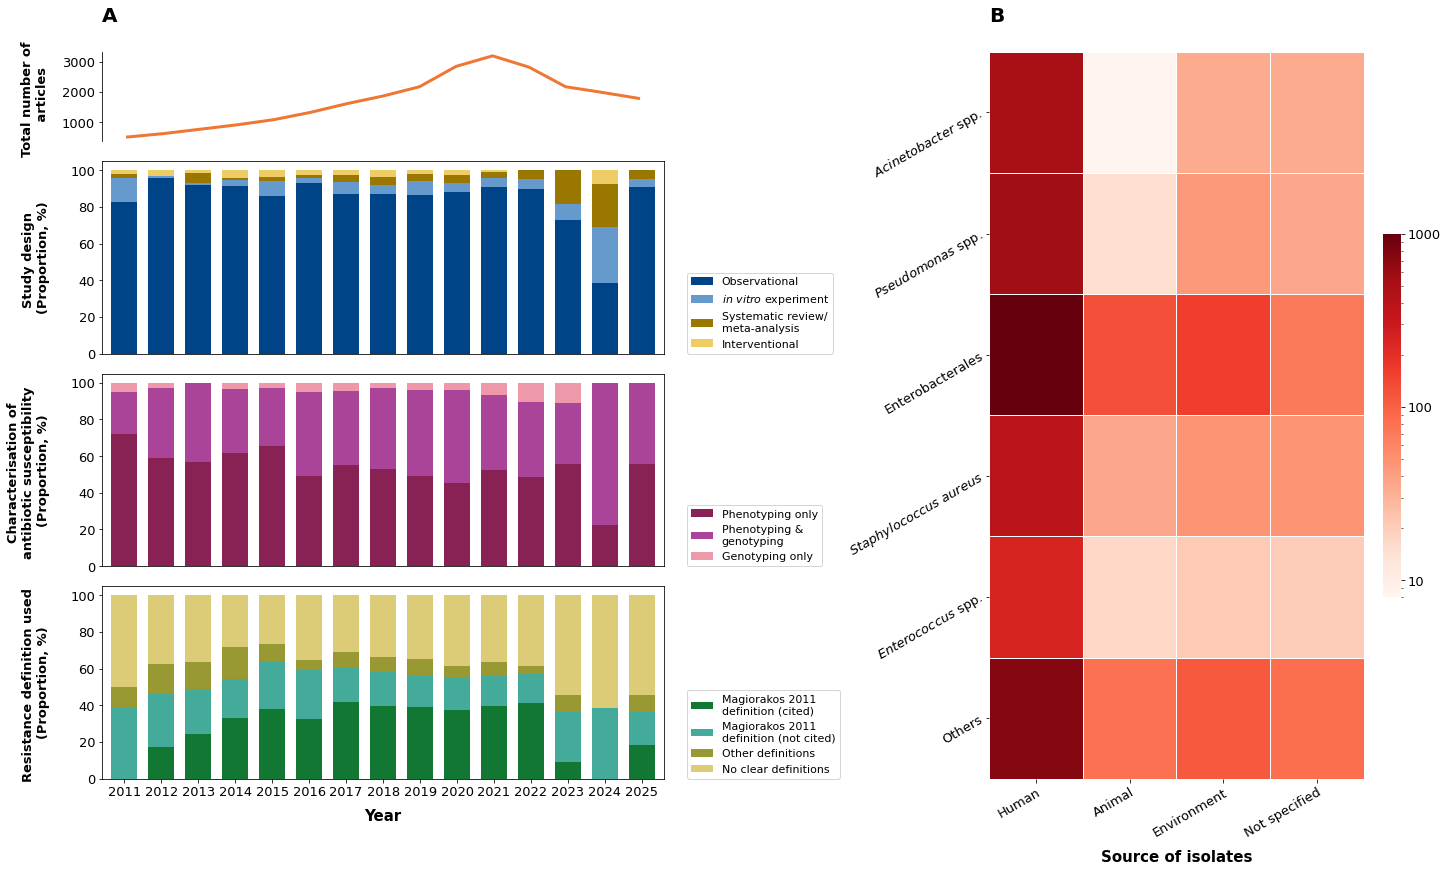

In [48]:
### FIGURE 2 - STUDY CHARACTERISTICS ####

# Total number of publications retrieved over the years 

years = list(set(df_inc['year']))
years.sort()
totalarticles=[]
for year in years:
    total = df.loc[df['year']== year].shape[0]
    screened = df1.loc[df1['year']== year].shape[0]
    included = df_inc.loc[df_inc['year']== year].shape[0]
    excluded = df_exc.loc[df_exc['year']== year].shape[0]
    totalarticles.append([total])

totalarticles = pd.DataFrame(totalarticles,columns=['Total'],index = years)
totalarticles=totalarticles.reset_index()
totalarticles.rename(columns={'index': 'Year'},inplace=True)

# Study design 

studytypedata = pd.DataFrame(df_analysis['study_type'])
studytypedata = pd.get_dummies(studytypedata)
studytypedata = studytypedata.rename(columns={'study_type_in vitro experiment':'invitro',
                                              'study_type_interventional':'interven',
                                              'study_type_observational':'ob',
                                              'study_type_systematic review/metaanalysis':'sr'})
studytypedata['year'] = df_analysis['year']

studydesign=[]
for y in years:
    article = studytypedata.query(f'year == {y}').shape[0]
    ob = round((studytypedata.query(f'year == {y} & ob == 1').shape[0])/article*100,2)
    invitro = round((studytypedata.query(f'year == {y} & invitro == 1').shape[0])/article*100,2)
    sr = round((studytypedata.query(f'year == {y} & sr == 1').shape[0])/article*100,2)
    interven = round((studytypedata.query(f'year == {y} & interven == 1').shape[0])/article*100,2)
    studydesign.append([ob,invitro,sr,interven])

studydesigndata = pd.DataFrame(studydesign, columns = ['Observational','$\it{in vitro}$ experiment',
                                                       'Systematic review/meta-analysis','Interventional'],index = years)

# Characterisation of antibiotic susceptibility 

typingdata = pd.DataFrame(df_analysis['typing'])
typingdata.drop(typingdata[typingdata['typing']=='not specified'].index,inplace=True)
typingdata = pd.get_dummies(typingdata)
typingdata = typingdata.rename(columns={'typing_genotype only':'geno',
                                        'typing_phenotype and genotype':'phenogeno',
                                        'typing_phenotype only':'pheno'})
typingdata['year'] = df_analysis['year']

typingtrend=[]
for y in years: 
    article = typingdata.query(f'year == {y}').shape[0]
    pheno = round((typingdata.query(f'year == {y} & pheno == 1').shape[0])/article*100,2)
    geno = round((typingdata.query(f'year == {y} & geno == 1').shape[0])/article*100,2)
    phenogeno = round((typingdata.query(f'year == {y} & phenogeno == 1').shape[0])/article*100,2)
    typingtrend.append([pheno,phenogeno,geno])

typedata = pd.DataFrame(typingtrend,columns = ['Phenotyping only','Phenotyping & genotyping', 'Genotyping only'],index = years)

# Drug resistance definitions used 

cite = []
for row in df_inc['cite_definition']:
    if row == 'cited Magiorakos 2011':
        cite.append(1)
    else:
        cite.append(0)
df_inc['cite'] = cite

nocitedef = ['not cited but same definition', 'not cited different definition','not cited without clear definition']
nocite = {}
for i in nocitedef:
    nocite[i] = []
    for row in df_inc['cite_definition']:
        if row == i:
            nocite[i].append(1)
        else:
            nocite[i].append(0)
for i in nocitedef:
    df_inc[i] = nocite[i]

df_inc.rename({'not cited but same definition':'samedef', 'not cited different definition':'diffdef','not cited without clear definition':'nodef'}, axis=1, inplace=True)

citelist = list(set(df_inc['cite_definition']))
citedef = []
for y in years:
    article = df_inc.query(f'year == {y}').shape[0]
    cited = round((df_inc.query(f'year == {y} & cite == 1').shape[0])/article*100,2)
    samedef = round((df_inc.query(f'year == {y} & samedef == 1').shape[0])/article*100,2)
    diffdef = round((df_inc.query(f'year == {y} & diffdef == 1').shape[0])/article*100,2)
    nodef = round((df_inc.query(f'year == {y} & nodef == 1').shape[0])/article*100,2)
    citedef.append([cited,samedef,diffdef,nodef])

citedata = pd.DataFrame(citedef,columns = ['Magiorakos 2011 definition (cited)', 'Magiorakos 2011 definition (not cited)',
                                           'Other definitions','No clear definitions'],index = years)

### ABSOLUTE NUMBERS BETWEEN SAMPLING SOURCE AND MICROORGANISMS ###

# Separate analysis dataframe for different categorisation of microorganisms (mainly gram positives)
df_analysis2 = pd.DataFrame()
df_analysis2['study_population'] = df_inc['study_population']
df_analysis2['abaum'] = df_inc['abaum_organism']
df_analysis2['paeru'] = df_inc['paeru_organism']
df_analysis2['saureus'] = df_inc['saureus_organism']
df_analysis2['enterococcus'] = df_inc['enterococcus_organism']
df_analysis2['enterobacterales'] = df_inc['enterobacterales_organism']

# Combining grampos and otherneg from df_analysis
others = []
for x in list(zip(df_analysis['grampos'],df_analysis['otherneg'])):
    if 1 in x:
        others.append(1)
    else:
        others.append(0)
df_analysis2['others'] = others

df_analysis2['study_population'] = df_analysis2['study_population'].replace(['unknown', 'NA'],'not specified')
df_analysis2['abaum'] = df_analysis2['abaum'].replace(['NA'],0)
df_analysis2['paeru'] = df_analysis2['paeru'].replace(['NA'],0)
df_analysis2['saureus'] = df_analysis2['saureus'].replace(['NA'],0)
df_analysis2['enterococcus'] = df_analysis2['enterococcus'].replace(['NA'],0)
df_analysis2['enterobacterales'] = df_analysis2['enterobacterales'].replace(['NA'],0)
df_analysis2 = df_analysis2.astype({'abaum': 'int64','paeru': 'int64','saureus': 'int64','enterococcus': 'int64','enterobacterales': 'int64'})


### DATAFRAME FOR STUDY POPULATION AND BACTERIA ####
# Create human, animal, environment columns based on study population

human = []
animal = []
envir = []
notspecified = []
for studypop in df_analysis2['study_population']:
    if studypop == 'not specified':
        human.append(0)
        animal.append(0)
        envir.append(0)
        notspecified.append(1)
    elif studypop == 'human':
        human.append(1)
        animal.append(0)
        envir.append(0)
        notspecified.append(0)
    elif studypop == 'animal':
        human.append(0)
        animal.append(1)
        envir.append(0)
        notspecified.append(0)
    elif studypop == 'environment':
        human.append(0)
        animal.append(0)
        envir.append(1)
        notspecified.append(0)
    elif studypop == 'human-animal':
        human.append(1)
        animal.append(1)
        envir.append(0)
        notspecified.append(0)
    elif studypop == 'human-envir':
        human.append(1)
        animal.append(0)
        envir.append(1)
        notspecified.append(0)
    elif studypop == 'human-animal-envir':
        human.append(1)
        animal.append(1)
        envir.append(1)
        notspecified.append(0)
    elif studypop == 'animal-envir':
        human.append(0)
        animal.append(1)
        envir.append(1)
        notspecified.append(0)

df_analysis2['human'] = human
df_analysis2['animal'] = animal
df_analysis2['envir'] = envir
df_analysis2['not specified'] = notspecified

fig2bdata = {key: [] for key in df_analysis2.columns[-4:]}

for x in df_analysis2.columns[-4:]: # Columns for human, animal, envir, not specified
    for y in df_analysis2.columns[1:7]:
        count = df_analysis2[(df_analysis2[x] == 1) & (df_analysis2[y] == 1)].shape[0]
        fig2bdata[x].append(count)
        
fig2bdata2 = pd.DataFrame(fig2bdata)
fig2bdata2 = fig2bdata2.rename(index={0:'$\it{Acinetobacter}$ spp.',1:'$\it{Pseudomonas}$ spp.',4:'Enterobacterales',
                                      3:'$\it{Enterococcus}$ spp.',2:'$\it{Staphylococcus}$ $\it{aureus}$',
                                      5:'Others'},
                               columns={'not specified':'Not specified',
                                        'animal':'Animal',
                                        'envir':'Environment',
                                        'human':'Human'})
fig2bdata2 = fig2bdata2.reindex(['$\it{Acinetobacter}$ spp.','$\it{Pseudomonas}$ spp.','Enterobacterales','$\it{Staphylococcus}$ $\it{aureus}$',
                                 '$\it{Enterococcus}$ spp.','Others'])

fig2bdata2

### PLOTTING OF FIGURE 2A AND 2B ###

fig = plt.figure(figsize=(20,12),constrained_layout=True)
#fig.tight_layout(pad = 2, w_pad = 20, h_pad = 5)

ax = fig.add_gridspec(7, 5)
ax1 = fig.add_subplot(ax[0,0:3])
ax1.plot(totalarticles['Year'],totalarticles['Total'],color = '#EE7733',linewidth = 3)
ax1.set_title('A',fontweight="bold", fontsize = 20, pad = 30, loc = 'left')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.set_ylabel('Total number of \n articles', fontweight = "bold", fontsize = 13, labelpad = 13)
ax1.tick_params(axis='both', labelsize=13)
ax1.xaxis.set_visible(False)

# Study design

ax2 = fig.add_subplot(ax[1:3,0:3]) 
studydesigndata.plot(ax = ax2, kind = 'bar', stacked = True, color = ['#004488','#6699CC','#997700','#EECC66'], width = 0.7)
ax2.legend(['Observational', '$\it{in}$ $\it{vitro}$ experiment', 'Systematic review/\nmeta-analysis','Interventional'],
            bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0,prop={'size':11})
ax2.xaxis.set_visible(False)
ax2.set_ylabel('Study design \n(Proportion, %)', fontweight = "bold", fontsize = 13, labelpad = 20)
fig.canvas.draw()
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize = 13, rotation = 0)

# Characterisation of antibiotic susceptibility

ax3 = fig.add_subplot(ax[3:5,0:3]) 
typedata.plot(ax = ax3, kind = 'bar', stacked = True, color = ['#882255','#AA4499','#EE99AA'], width = 0.7)
ax3.xaxis.set_visible(False)
ax3.legend(['Phenotyping only', 'Phenotyping & \ngenotyping', 'Genotyping only','Not specified'],
            bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0,prop={'size':11})
ax3.set_ylabel('Characterisation of \nantibiotic susceptibility \n(Proportion, %)', fontweight = "bold", fontsize = 13, labelpad = 20)
fig.canvas.draw()
ax3.set_yticklabels(ax3.get_yticklabels(),fontsize = 13, rotation = 0)

# Resistance definitions used

ax4 = fig.add_subplot(ax[5:7,0:3]) 
citedata.plot(ax = ax4, kind='bar', stacked=True, color = ['#117733','#44AA99','#999933','#DDCC77'], width = 0.7)
ax4.legend(['Magiorakos 2011 \ndefinition (cited)',
            'Magiorakos 2011\ndefinition (not cited)',
            'Other definitions', 'No clear definitions'],bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0,prop={'size':11})
ax4.set_ylabel('Resistance definition used \n(Proportion, %)', fontweight = "bold", fontsize = 13, labelpad = 20)
ax4.set_xticklabels(ax4.get_xticklabels(),fontsize = 13, rotation = 0)
fig.canvas.draw()
ax4.set_yticklabels(ax4.get_yticklabels(),fontsize = 13, rotation = 0)
ax4.set_xlabel('Year', fontweight = "bold", fontsize = 15, labelpad = 10)

# Heatmap
ax5 = fig.add_subplot(ax[0:,3:])
ax5 = sns.heatmap(fig2bdata2,linewidth=0.5,cmap='Reds', norm=LogNorm(), 
                  cbar_kws={"shrink": 0.5,"ticks":[10,1e2,1e3]},vmin = 0, vmax = 1000)
ax5.set_title('B',fontweight="bold", fontsize = 20, pad = 30, loc = 'left')
ax5.set_xlabel('Source of isolates', fontweight = "bold", fontsize = 15, labelpad = 10)
ax5.set_xticklabels(ax5.get_xticklabels(),fontsize = 13, rotation = 30, ha = 'right', rotation_mode = 'anchor')
ax5.set_yticklabels(ax5.get_yticklabels(),fontsize = 13, rotation = 30, rotation_mode = 'anchor')
cbar = ax5.collections[0].colorbar
cbar.ax.tick_params(labelsize = 13)
cbar.ax.set_yticklabels([10,100,1000])

fig = fig.get_figure()
fig.savefig("Figure 2.png",dpi=300,bbox_inches="tight",facecolor='w')

In [49]:
# Re-categorising data for regression 

df_analysis['infection'] = df_analysis['infection'].replace(['combination','other infections','non-clinical','gi or intraabdominal',
                                                             'urinary','respiratory'],
                                                            ['other infection source','other infection source','screening samples','gastrointestinal tract',
                                                             'urinary tract','respiratory tract'])
df_analysis['study_type'] = df_analysis['study_type'].replace(['systematic review/metaanalysis'],'systematic review/meta-analysis')
df_analysis['typing'] = df_analysis['typing'].replace(['no typing done/specified'],'not specified')
df_analysis['susguide'] = df_analysis['susguide'].replace(['no guidelines used/specified','other guidelines only'],'others/not specified')
df_analysis

,number,title,year,study_type,infection,term,typing,susguide,entero,nonfermenters,otherneg,grampos,cite
3,4,A γ-lactam siderophore antibiotic effective ag...,2021,observational,other infection source,mdr only,phenotype only,clsi only,1,1,0,0,0
5,6,"β-Lactamases, transferable quinolone resistanc...",2013,observational,other infection source,mdr only,phenotype and genotype,clsi only,1,0,0,0,1
7,8,β-lactamase genes in carbapenem resistance aci...,2019,observational,other infection source,"mdr, xdr and pdr in various combinations",phenotype and genotype,clsi only,0,1,0,0,1
11,12,Zoonotic potential of multidrug-resistant Esch...,2012,observational,other infection source,mdr only,phenotype and genotype,eucast only,1,0,0,0,0
14,15,Zoonotic Potential and Antibiotic Resistance o...,2017,observational,screening samples,mdr only,phenotype and genotype,eucast and clsi,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30389,30390,Retrospective study: China's pediatric hospita...,2025,observational,other infection source,mdr only,phenotype only,others/not specified,1,1,0,1,0
30441,30442,Public health threat of antimicrobial resistan...,2025,observational,other infection source,"mdr, xdr and pdr",phenotype and genotype,clsi only,1,0,0,0,1
30478,30479,"Proteomics-guided Biomarker Discovery, Validat...",2025,observational,other infection source,mdr only,not specified,others/not specified,0,0,0,1,0
30544,30545,Recreational Facilities as Reservoirs for Mult...,2025,observational,screening samples,mdr only,phenotype only,others/not specified,0,0,0,1,0


In [56]:
#Create univariate logistic regression table

modeldata = df_analysis[['cite','study_type','infection','term','typing','susguide','entero', 'nonfermenters', 'grampos','otherneg']]

# Study type

model_study = smf.logit("cite ~ C(study_type, Treatment(reference='observational'))",data=modeldata[['cite','study_type']]).fit()
params_study = model_study.params

conf_study = model_study.conf_int()
conf_study['Odds Ratio'] = params_study
conf_study.columns = ['2.5%', '97.5%', 'Odds Ratio']

odds_study = pd.DataFrame({"Odds Ratio": conf_study['Odds Ratio'],
                            "Lower CI": conf_study['2.5%'],
                            "Upper CI": conf_study['97.5%']})

odds_study = np.exp(odds_study)
odds_study['P-values'] = model_study.pvalues
odds_study['Significant?'] = ['Significant' if pval <= 0.05 else 'Not significant' for pval in model_study.pvalues]


# Infection source

model_infect = smf.logit("cite ~ C(infection, Treatment(reference='screening samples'))",data=modeldata[['cite','infection']]).fit()
params_infect = model_infect.params

conf_infect = model_infect.conf_int()
conf_infect['Odds Ratio'] = params_infect
conf_infect.columns = ['2.5%', '97.5%', 'Odds Ratio']


odds_infect = pd.DataFrame({"Odds Ratio": conf_infect['Odds Ratio'],
                            "Lower CI": conf_infect['2.5%'],
                            "Upper CI": conf_infect['97.5%']})

odds_infect = np.exp(odds_infect)
odds_infect['P-values'] = model_infect.pvalues
odds_infect['Significant?'] = ['Significant' if pval <= 0.05 else 'Not significant' for pval in model_infect.pvalues]

# Drug resistance terms

model_term = smf.logit("cite ~ C(term, Treatment(reference='mdr only'))",data=modeldata[['cite','term']]).fit()
params_term = model_term.params

conf_term = model_term.conf_int() 
conf_term['Odds Ratio'] = params_term
conf_term.columns = ['2.5%', '97.5%', 'Odds Ratio']


odds_term = pd.DataFrame({"Odds Ratio": conf_term['Odds Ratio'],
                            "Lower CI": conf_term['2.5%'],
                            "Upper CI": conf_term['97.5%']})

odds_term = np.exp(odds_term)
odds_term['P-values'] = model_term.pvalues
odds_term['Significant?'] = ['Significant' if pval <= 0.05 else 'Not significant' for pval in model_term.pvalues]

# Characterisation of antibiotic susceptibilities

model_typing = smf.logit("cite ~ C(typing, Treatment(reference='phenotype only'))",data=modeldata[['cite','typing']]).fit()
params_typing = model_typing.params

conf_typing = model_typing.conf_int()
conf_typing['Odds Ratio'] = params_typing
conf_typing.columns = ['2.5%', '97.5%', 'Odds Ratio'] 

odds_typing = pd.DataFrame({"Odds Ratio": conf_typing['Odds Ratio'],
                            "Lower CI": conf_typing['2.5%'],
                            "Upper CI": conf_typing['97.5%']})

odds_typing = np.exp(odds_typing)
odds_typing['P-values'] = model_typing.pvalues
odds_typing['Significant?'] = ['Significant' if pval <= 0.05 else 'Not significant' for pval in model_typing.pvalues]


# Antibiotic susceptibility standards

model_sus = smf.logit("cite ~ C(susguide, Treatment(reference='clsi only'))",data=modeldata[['cite','susguide']]).fit() 
params_sus = model_sus.params

conf_sus = model_sus.conf_int() 
conf_sus['Odds Ratio'] = params_sus
conf_sus.columns = ['2.5%', '97.5%', 'Odds Ratio']

odds_sus = pd.DataFrame({"Odds Ratio": conf_sus['Odds Ratio'],
                            "Lower CI": conf_sus['2.5%'],
                            "Upper CI": conf_sus['97.5%']})

odds_sus = np.exp(odds_sus)
odds_sus['P-values'] = model_sus.pvalues
odds_sus['Significant?'] = ['Significant' if pval <= 0.05 else 'Not significant' for pval in model_sus.pvalues]

# Enterobacterales

model_e = smf.logit("cite ~ C(entero, Treatment(reference=0))",data=modeldata[['cite','entero']]).fit()
params_e = model_e.params

conf_e = model_e.conf_int() 
conf_e['Odds Ratio'] = params_e
conf_e.columns = ['2.5%', '97.5%', 'Odds Ratio']

odds_e = pd.DataFrame({"Odds Ratio": conf_e['Odds Ratio'],
                            "Lower CI": conf_e['2.5%'],
                            "Upper CI": conf_e['97.5%']})

odds_e = np.exp(odds_e)
odds_e['P-values'] = model_e.pvalues
odds_e['Significant?'] = ['Significant' if pval <= 0.05 else 'Not significant' for pval in model_e.pvalues]
odds_e = odds_e.rename(index={'C(entero, Treatment(reference=0))[T.1]': 'C(entero, Treatment(reference=0))[T.Enterobacterales]'})

# Non-fermenters

model_nonferm = smf.logit("cite ~ C(nonfermenters, Treatment(reference=0))",data=modeldata[['cite','nonfermenters']]).fit()
params_nonferm = model_nonferm.params

conf_nonferm = model_nonferm.conf_int() 
conf_nonferm['Odds Ratio'] = params_nonferm
conf_nonferm.columns = ['2.5%', '97.5%', 'Odds Ratio']

odds_nonferm = pd.DataFrame({"Odds Ratio": conf_nonferm['Odds Ratio'],
                            "Lower CI": conf_nonferm['2.5%'],
                            "Upper CI": conf_nonferm['97.5%']})

odds_nonferm = np.exp(odds_nonferm)
odds_nonferm['P-values'] = model_nonferm.pvalues
odds_nonferm['Significant?'] = ['Significant' if pval <= 0.05 else 'Not significant' for pval in model_nonferm.pvalues]
odds_nonferm = odds_nonferm.rename(index={'C(nonfermenters, Treatment(reference=0))[T.1]': 'C(entero, Treatment(reference=0))[T.Non-fermenting Gram-negative]'})

#Gram-positive bacteria

model_grampos = smf.logit("cite ~ C(grampos, Treatment(reference=0))",data=modeldata[['cite','grampos',]]).fit()
params_grampos = model_grampos.params

conf_grampos = model_grampos.conf_int()
conf_grampos['Odds Ratio'] = params_grampos
conf_grampos.columns = ['2.5%', '97.5%', 'Odds Ratio']

odds_grampos = pd.DataFrame({"Odds Ratio": conf_grampos['Odds Ratio'],
                            "Lower CI": conf_grampos['2.5%'],
                            "Upper CI": conf_grampos['97.5%']})

odds_grampos = np.exp(odds_grampos)
odds_grampos['P-values'] = model_grampos.pvalues
odds_grampos['Significant?'] = ['Significant' if pval <= 0.05 else 'Not significant' for pval in model_grampos.pvalues]
odds_grampos = odds_grampos.rename(index={'C(grampos, Treatment(reference=0))[T.1]': 'C(grampos, Treatment(reference=0))[T.Gram-positive]'})

# Other Gram-negative bacteria

model_otherneg = smf.logit("cite ~ C(otherneg, Treatment(reference=0))",data=modeldata[['cite','otherneg']]).fit()
params_otherneg = model_otherneg.params

conf_otherneg = model_otherneg.conf_int() #confidence interval
conf_otherneg['Odds Ratio'] = params_otherneg
conf_otherneg.columns = ['2.5%', '97.5%', 'Odds Ratio']

odds_otherneg = pd.DataFrame({"Odds Ratio": conf_otherneg['Odds Ratio'],
                            "Lower CI": conf_otherneg['2.5%'],
                            "Upper CI": conf_otherneg['97.5%']})

odds_otherneg = np.exp(odds_otherneg)
odds_otherneg['P-values'] = model_otherneg.pvalues
odds_otherneg['Significant?'] = ['Significant' if pval <= 0.05 else 'Not significant' for pval in model_otherneg.pvalues]
odds_otherneg = odds_otherneg.rename(index={'C(otherneg, Treatment(reference=0))[T.1]': 'C(entero, Treatment(reference=0))[T.Other Gram-negative]'})

# Combining univariate regression into a single table

odds = pd.concat([odds_study, odds_infect, odds_term, odds_typing, odds_sus,odds_e, odds_nonferm,odds_grampos, odds_otherneg], axis=0)
odds = odds[odds.index != "Intercept"]

odds = odds.rename(index=lambda s: s.split('.')[1][:-1])
odds = odds.rename({'in vitro experiment':'in vitro experiment',
                    'interventional': 'Interventional',
                    'systematic review/meta-analysis':'Systematic review/meta-analysis',
                    'bloodstream':'Bloodstream',
                    'gastrointestinal tract': 'Gastrointestinal tract',
                    'other infection source':'Other infection source',
                    'respiratory tract':'Respiratory tract',
                    'urinary tract':'Urinary tract',
                    'mdr, xdr and pdr':'MDR, XDR and PDR',
                    'mdr, xdr and pdr in various combinations':'MDR, XDR and PDR in various combinations',
                    'not specified': 'Not specified',
                    'phenotype and genotype': 'Phenotype and genotype',
                    'genotype only':'Genotype only',
                    'eucast and clsi':'EUCAST and CLSI',
                    'eucast only':'EUCAST only',
                    'others/not specified':'Others/not specified',
                    'Non-fermenting Gram-negative':'Non-fermenting Gram-negative',
                    'Gram-positive':'Gram-positive',
                    'Other Gram-negative': 'Other Gram-negative'})
odds['label'] = odds.index.to_list()

def grouplabel(x):
    grouping = {'Study design (Ref: Observational)':['in vitro', 'review', 'interventional'],
                'Drug resistance terms used (Ref: MDR only)':['mdr', 'xdr', 'pdr', 'dtr', 'udr', 'term'],
                'Antibiotic susceptibility standards (Ref: CLSI only)':['eucast','clsi','guideline','others'],
                'Characterisation of antibiotic susceptibilities (Ref: Phenotype only)':['typ','not specified'],
                'Clinical source of bacteria isolates (Ref: Screening samples)':['blood','gastro', 'clinical', 'infection', 'respiratory', 'urinary'],
                'missing':['missing'],'Enterobacterales':['enterob'],'Non-fermenting Gram-negative':['non-ferm'],
                'Other Gram-negative':['neg'],'Gram-positive':['pos']}
    for g in grouping:
        for val in grouping[g]:
            if val in x.lower():
                return g
            else:
                continue
                
group=[]
for i in odds['label']:
    group.append(grouplabel(i.lower()))

odds['group'] = group
odds.drop(odds[odds['group']=='missing'].index,inplace=True)

ncount={}
ncount.update(df_analysis['study_type'].value_counts().to_dict())
ncount.update(df_analysis['infection'].value_counts().to_dict())
ncount.update(df_analysis['susguide'].value_counts().to_dict())
ncount.update(df_analysis['typing'].value_counts().to_dict())
ncount.update(df_analysis['term'].value_counts().to_dict())
ncount.update({'enterobacterales': df_analysis[df_analysis['entero']==1].shape[0]})
ncount.update({'non-fermenting gram-negative': df_analysis[df_analysis['nonfermenters']==1].shape[0]})
ncount.update({'gram-positive': df_analysis[df_analysis['grampos']==1].shape[0]})
ncount.update({'other gram-negative': df_analysis[df_analysis['otherneg']==1].shape[0]})

n=[]
for x in odds['label']:
    n.append(str(ncount[x.lower()]))
odds['n'] = n
odds['P-values']=odds['P-values'].round(3)

from forestplot.text_utils import star_pval
from forestplot.arg_validators import check_iterables_samelen

odds = star_pval(dataframe=odds, pval="P-values", starpval=True, decimal_precision=3, thresholds=(0.050,0.050), symbols=("**","**"))
odds = odds.replace(['0.0**'],'0.000**')
odds = odds.reindex(['Interventional','Systematic review/meta-analysis','in vitro experiment','Bloodstream','Respiratory tract',
                     'Urinary tract','Gastrointestinal tract','Other infection source','MDR, XDR and PDR', 'MDR, XDR and PDR in various combinations', 
                     'Genotype only','Phenotype and genotype','Not specified','EUCAST only','EUCAST and CLSI','Others/not specified','Enterobacterales',
                     'Non-fermenting Gram-negative','Other Gram-negative','Gram-positive'])
odds['label'] = odds['label'].replace(['Enterobacterales'],'Enterobacterales studied')
odds['label'] = odds['label'].replace(['Non-fermenting Gram-negative'],'Non-fermenting Gram-negative studied')
odds['label'] = odds['label'].replace(['Other Gram-negative'],'Other Gram-negative studied')
odds['label'] = odds['label'].replace(['Gram-positive'],'Gram-positive studied')
odds = odds.replace(['in vitro experiment'],'$\it{in}$ $\it{vitro}$ experiment')
odds
#odds.to_excel('odds_uni.xlsx', index=False)

Optimization terminated successfully.
         Current function value: 0.668866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684908
         Iterations 4


In [55]:
# Create multivariate logistic regression with forestplot

df_analysis3 = df_analysis[df_analysis['infection'] != 'missing']

modeldata2 = df_analysis3[['cite','study_type','infection','term','typing','susguide','entero', 'nonfermenters', 'grampos','otherneg']] 
model2 = smf.logit("cite ~ C(study_type, Treatment(reference='observational')) + C(infection, Treatment(reference='screening samples')) + C(term, Treatment(reference='mdr only')) + C(typing, Treatment(reference='phenotype only'))+ C(susguide, Treatment(reference='clsi only')) + entero + nonfermenters + grampos + otherneg",
                        data=modeldata2).fit()

params2 = model2.params
conf2 = model2.conf_int()
conf2['Odds Ratio'] = params2
conf2.columns = ['2.5%', '97.5%', 'Odds Ratio']

odds2 = pd.DataFrame({"Odds Ratio": conf2['Odds Ratio'],
                            "Lower CI": conf2['2.5%'],
                            "Upper CI": conf2['97.5%']})

odds2 = np.exp(odds2)
odds2['P-values'] = model2.pvalues
odds2['Significant?'] = ['Significant' if pval <= 0.05 else 'Not significant' for pval in model2.pvalues]
odds2 = odds2[odds2.index != "Intercept"]
odds2 = odds2.rename(index=lambda s: s.split('.')[1][:-1] if '.' in s else s)

odds2 = odds2.rename({'in vitro experiment':'in vitro experiment',
                      'interventional': 'Interventional',
                      'systematic review/meta-analysis':'Systematic review/meta-analysis',
                      'bloodstream':'Bloodstream',
                      'combination':'Combination',
                      'gastrointestinal tract': 'Gastrointestinal tract',
                      'other infection source':'Other infection source',
                      'respiratory tract':'Respiratory tract',
                      'urinary tract':'Urinary tract',
                      'mdr, xdr and pdr':'MDR, XDR and PDR',
                      'mdr, xdr and pdr in various combinations':'MDR, XDR and PDR in various combinations',
                      'not specified': 'Not specified',
                      'phenotype and genotype': 'Phenotype and genotype',
                      'genotype only':'Genotype only',
                      'eucast and clsi':'EUCAST and CLSI',
                      'eucast only':'EUCAST only',
                      'others/not specified':'Others/not specified',
                      'entero':'Enterobacterales',
                      'nonfermenters':'Non-fermenting Gram-negative',
                      'grampos':'Gram-positive',
                      'otherneg': 'Other Gram-negative'})
odds2['label'] = odds2.index.to_list()

group2=[]

for i in odds2['label']:
    group2.append(grouplabel(i))
odds2['group'] = group2

ncount2={}
ncount2.update(df_analysis3['study_type'].value_counts().to_dict())
ncount2.update(df_analysis3['infection'].value_counts().to_dict())
ncount2.update(df_analysis3['susguide'].value_counts().to_dict())
ncount2.update(df_analysis3['typing'].value_counts().to_dict())
ncount2.update(df_analysis3['term'].value_counts().to_dict())
ncount2.update({'enterobacterales': df_analysis3[df_analysis3['entero']==1].shape[0]})
ncount2.update({'non-fermenting gram-negative': df_analysis3[df_analysis3['nonfermenters']==1].shape[0]})
ncount2.update({'gram-positive': df_analysis3[df_analysis3['grampos']==1].shape[0]})
ncount2.update({'other gram-negative': df_analysis3[df_analysis3['otherneg']==1].shape[0]})
ncount2 = {k.lower(): v for k, v in ncount2.items()}
ncount2

n=[]
for x in odds2['label']:
    n.append(str(ncount2[x.lower()]))
odds2['n'] = n
odds2['P-values']=odds2['P-values'].round(3)

odds2 = star_pval(dataframe=odds2, pval="P-values", starpval=True, decimal_precision=3, thresholds=(0.05,0.05), symbols=("**","**"))
odds2 = odds2.replace(['0.0**'],'0.00**')
odds2=odds2.reindex(['Interventional','Systematic review/meta-analysis','in vitro experiment','Bloodstream','Respiratory tract','Urinary tract',
                     'Gastrointestinal tract','Other infection source','MDR, XDR and PDR', 'MDR, XDR and PDR in various combinations', 
                     'Genotype only','Phenotype and genotype','Not specified','EUCAST only','EUCAST and CLSI','Others/not specified','Enterobacterales',
                     'Non-fermenting Gram-negative','Other Gram-negative','Gram-positive'])
odds2['label'] = odds2['label'].replace(['Enterobacterales'],'Enterobacterales studied')
odds2['label'] = odds2['label'].replace(['Non-fermenting Gram-negative'],'Non-fermenting Gram-negative studied')
odds2['label'] = odds2['label'].replace(['Other Gram-negative'],'Other Gram-negative studied')
odds2['label'] = odds2['label'].replace(['Gram-positive'],'Gram-positive studied')
odds2 = odds2.replace(['in vitro experiment'],'$\it{in}$ $\it{vitro}$ experiment')
odds2
#odds2.to_excel('odds_multi.xlsx', index=False)

Optimization terminated successfully.
         Current function value: 0.609453
         Iterations 6


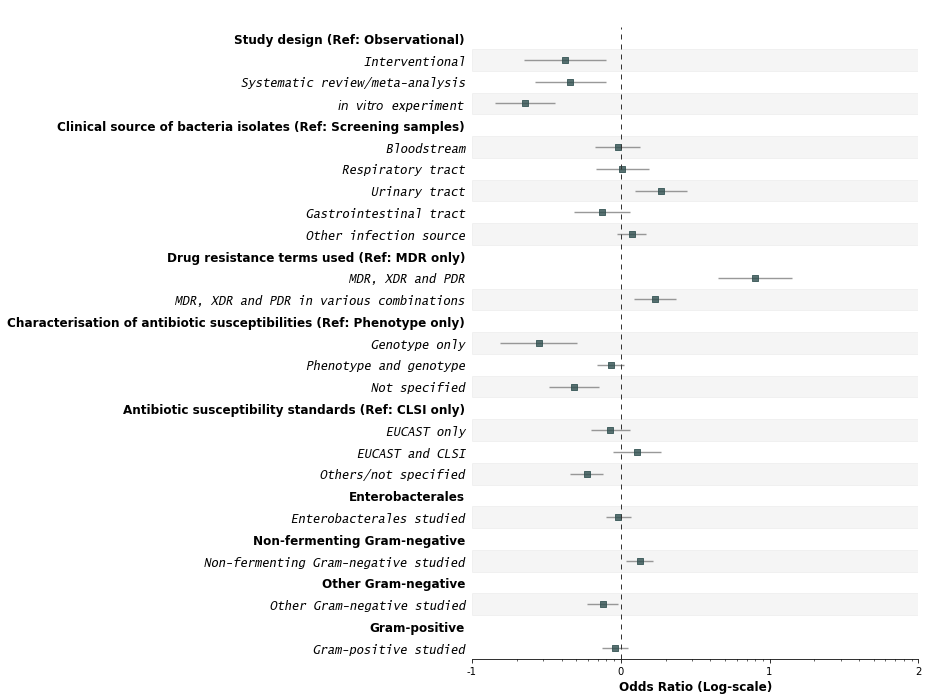

In [9]:
fig_odds = fp.forestplot(odds2,
                          estimate="Odds Ratio",  
                          ll="Lower CI", hl="Upper CI", 
                          varlabel="label",  
                          ci_report=False,
                          xlabel="Odds Ratio (Log-scale)",
                          groupvar="group",
                          logscale=True,
                          flush=False,
                          color_alt_rows=True,
                          figsize=(8,12),
                          xline=1,xlinestyle = (0, (5, 5)),
                          xticks=[0.1,1,10,100], xticklabels = [-1,0,1,2])  
fig_odds = fig_odds.get_figure()
fig_odds.savefig("3 OR plot_Multivariate_NEW.png",dpi=300,bbox_inches='tight')

In [8]:
Credit:Shen, L. (2022). Forestplot. https://doi.org/10.5281/zenodo.7029377

SyntaxError: invalid syntax (3884783015.py, line 1)

NameError: name 'data12temp' is not defined